In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3984895428


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 100,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    'warmup_factor': 2
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 2,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 3984895428,
 'num_epoch': 100,
 'to_freeze_count': 155}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PlayerReply c "Why did you do it, Izumi? Why did you kill them?" scn np1n<|endoftext|>PlayerReply c "I see." DragonReply Ry "How about you, [player_name]? Would you like to have children one day?" PlayerReply c "Yes." PlayerReply c "I think I would." DragonReply Ry "Just being able to teach them about the world and watch them grow up... Having a little family would be nice. I'd like that a lot."<|endoftext|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>
[0] set freeze_part_layers: True (freezing 155 out of 160 layers.)


Step,Training Loss
42,2.924500
84,2.264100
126,2.106200
168,2.037800
210,1.952800
252,1.878200
294,1.867300
336,1.838600
378,1.831500
420,1.794200


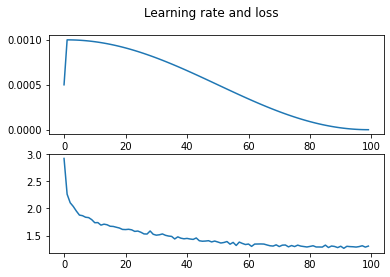

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "Very nice."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "I'm fine." DragonReply Ry "I'm fine. I'm fine." DragonReply Ry "I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine


Prompt: What do you think of Lorem?
Reply: Ad "I'm not sure."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: An "Oh my god, Adine. What is this?"<|endoftext|>


Prompt: What will we do here?
Reply: An "I sat down on a chair in Anna's lab. What will we do here? PlayerReply c "I sat down on a chair in Anna's lab. What will we do here? DragonReply An "I sat down on a chair in Anna's lab. What will we do here?<|endoftext|>




# Sampling test

Which combination is the best?

In [9]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 9, top_p: 0.54] -> Prompt: How are you?
Reply: Ry "I'm fine." DragonReply Ry "I'm fine." DragonReply Ry "I'm fine. I'm fine." DragonReply Ry "I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine

[Test 1 top_k: 9, top_p: 0.54] -> Prompt: What do you think of Lorem?
Reply: Ad "I think he's a very good person."<|endoftext|>

[Test 1 top_k: 9, top_p: 0.54] -> Prompt: Oh my god, Adine. What is this?
Reply: An "It's raining pretty heavily." DragonReply c "I'm not sure what to think. What do you think?"<|endoftext|>

[Test 1 top_k: 9, top_p: 0.54] -> Prompt: What will we do here?
Reply: Br "I sat down on a chair in Anna's lab. I sat down on a chair in Anna's lab, I sat down on a chair in Anna's lab, I sat down on a chair in Anna's lab, I sat down on a chair in Anna's lab, I sat down on a chair in Anna's lab, I sat down on a chair in Anna's lab

In [10]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined